<a href="https://colab.research.google.com/github/DeadPhoeni/TRINIT_-ENGIMA-ZEALOTS-_-Trackchosen-ML-/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

def xmltocsv(xmlpath, outputpath):
    xmllist = []
    for xml_file in glob.glob(os.path.join(xmlpath, "*.xml")):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall("object"):
            value = (
                root.find("filename").text,
                int(root.find("size").find("width").text),
                int(root.find("size").find("height").text),
                obj.find("name").text,
                int(obj.find("bndbox").find("xmin").text),
                int(obj.find("bndbox").find("ymin").text),
                int(obj.find("bndbox").find("xmax").text),
                int(obj.find("bndbox").find("ymax").text),
            )
            xmllist.append(value)

    columns = [
        "filename",
        "width",
        "height",
        "class",
        "xmin",
        "ymin",
        "xmax",
        "ymax",
    ]
    df = pd.DataFrame(xmllist, columns=columns)
    df.to_csv(outputpath, index=None)
    print(f"Successfully converted {len(xml_list)} XML files to {outputpath}")


xmlfolders = r"C:\Users\ravee\Documents\images dataset\Czech\train\annotations\xmls"
outputcsv = r"C:\Users\ravee\Documents\images dataset\Czech\train\train_Czech.csv"
xmltocsv(xmlfolder, outputcsv)


In [ ]:
import pandas as pd
import os
import yaml

def convert_to_yolo_format(csv_path, output_dir, img_dir):

    df = pd.read_csv(csv_path)

    unique_classes = df['class'].unique()
    class_mapping = {class_name: index for index, class_name in enumerate(unique_classes)}

    annotations = []


    for index, row in df.iterrows():
        imagename = row['filename']
        image_path = os.path.join(img_dir, imagename)
        class_name = row['class']
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        image_width, image_height = row['width'], row['height']

        x_center = (xmin + xmax) / (2 * image_width)
        y_center = (ymin + ymax) / (2 * image_height)
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height


        yolo_format = {
            'image_path': image_path,
            'class': class_mapping[class_name],
            'x_center': x_center,
            'y_center': y_center,
            'width': width,
            'height': height
        }

        annotations.append(yolo_format)

    yaml_file_path = os.path.join(output_dir, 'dataset.yaml')
    with open(yaml_file_path, 'w') as yaml_file:
        yaml.dump(annotations, yaml_file)


csv_path = r'/content/drive/MyDrive/project1/train_India.csv'
image_dir = r'/content/drive/MyDrive/project1/India/train/images'
output_dir = r'/content/drive/MyDrive/project1/dataset.yaml'


os.makedirs(output_dir, exist_ok=True)


convert_to_yolo_format(csv_path, output_dir, image_dir)


In [ ]:
import os
import cv2
import yaml
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset_path, batch_size):
        self.batch_size = batch_size
        self.dataset = self.load_dataset(dataset_path)

    def load_dataset(self, dataset_path):
        with open(dataset_path, 'r') as file:
            data = yaml.safe_load(file)
        return data

    def __len__(self):
        return int(np.ceil(len(self.dataset) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_data = self.dataset[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        labels = []

        for entry in batch_data:
            image = cv2.imread(entry['image_path'])
            if image is None:
                raise ValueError(f"Image not found at {entry['image_path']}")
            image = cv2.resize(image, (512, 512))
            image = image / 255.0

            label = [1.0] + [entry['x_center'], entry['y_center'], entry['width'], entry['height']]

            images.append(image)
            labels.append(label)

        return np.array(images), np.array(labels)


def build_yolo_model(input_shape=(512, 512, 3)):
    model = keras.Sequential()
    model.add(layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation='sigmoid'))

    return model


batch_size = 32
dataset_path = '/content/drive/MyDrive/project1/datasetyaml/dataset.yaml'
data_generator = CustomDataGenerator(dataset_path, batch_size)


yolo_model = build_yolo_model()


yolo_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


epochs = 5
yolo_model.fit(data_generator, epochs=epochs)


model_save_path = '/content/drive/MyDrive/project1/datasetyaml/model.h5'
yolo_model.save(model_save_path)


Epoch 1/5
257/257 [==============================] - 1097s 4s/step - loss: 0.0946 - accuracy: 0.9961
Epoch 2/5
257/257 [==============================] - 1104s 4s/step - loss: 0.0944 - accuracy: 1.0000
Epoch 3/5
257/257 [==============================] - 1101s 4s/step - loss: 0.0944 - accuracy: 1.0000
Epoch 4/5
257/257 [==============================] - 1086s 4s/step - loss: 0.0944 - accuracy: 1.0000
Epoch 5/5
257/257 [==============================] - 1079s 4s/step - loss: 0.0944 - accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score

def load_and_preprocess_test_images(test_images_folder, batch_size=100):
    test_images = []
    image_paths = []

    for filename in os.listdir(test_images_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(test_images_folder, filename)
            image = cv2.imread(image_path)

            if image is not None:
                image = cv2.resize(image, (512, 512))
                image = image / 255.0

                test_images.append(image)
                image_paths.append(image_path)


                if len(test_images) == batch_size:
                    yield np.array(test_images), image_paths
                    test_images = []
                    image_paths = []


    if len(test_images) > 0:
        yield np.array(test_images), image_paths


model_path = '/content/drive/MyDrive/project1/datasetyaml/model.h5'
yolo_model = keras.models.load_model(model_path)


test_images_folder = '/content/drive/MyDrive/project1/India/test/images'


total_detected_roads = 0
total_images = 0
threshold = 0.3


all_predictions = []
all_labels = []


for batch_images, batch_image_paths in load_and_preprocess_test_images(test_images_folder, batch_size):
    batch_predictions = yolo_model.predict(batch_images)

    batch_detected_roads = sum(1 for j in range(len(batch_predictions)) if batch_predictions[j][0] > threshold)
    total_detected_roads += batch_detected_roads
    total_images += len(batch_image_paths)


    all_predictions.extend(batch_predictions[:, 0])
    all_labels.extend([1 if pred > threshold else 0 for pred in batch_predictions[:, 0]])

    del batch_images
    del batch_predictions
    tf.keras.backend.clear_session()


accuracy = total_detected_roads / total_images
precision = accuracy
f1 = f1_score(all_labels, [1 if pred > threshold else 0 for pred in all_predictions])


print(f"Total images: {total_images}")
print(f"Detected road images: {total_detected_roads}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")


1/1 [==============================] - 0s 85ms/step


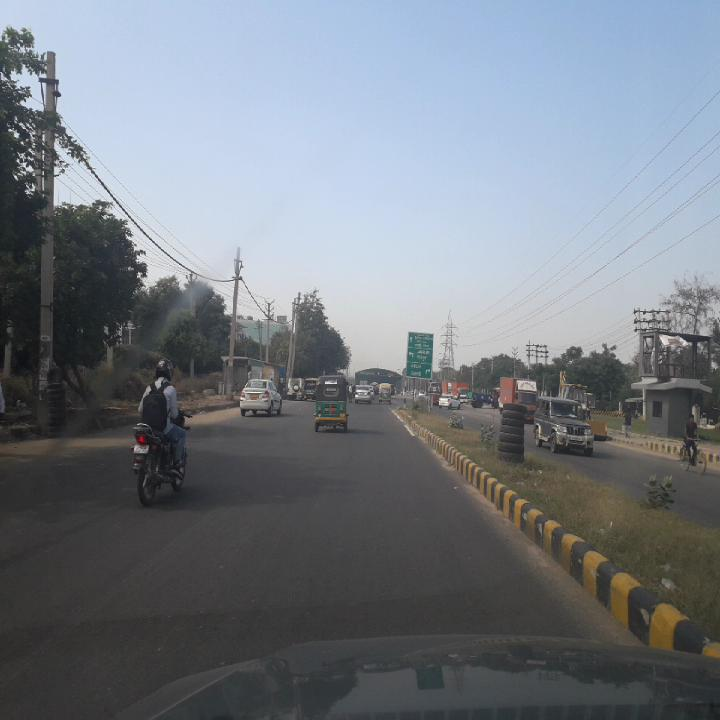

There is no damage in the road


In [40]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from google.colab.patches import cv2_imshow


def load_yolo_model(model_path):
    return keras.models.load_model(model_path)


def create_bounding_box(image, predictions):
    confidence_threshold = 0.5


    confidence, x_center, y_center, width, height = predictions

    if confidence >= confidence_threshold:

        image_height, image_width, _ = image.shape
        x_center = int(x_center * image_width)
        y_center = int(y_center * image_height)
        box_width = int(width * image_width)
        box_height = int(height * image_height)


        x_min = max(0, x_center - (box_width // 2))
        y_min = max(0, y_center - (box_height // 2))
        x_max = min(image_width, x_center + (box_width // 2))
        y_max = min(image_height, y_center + (box_height // 2))


        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        cv2_imshow(image)


        return x_min, y_min, x_max, y_max
    else:
        print("No crack detected.")
        return None


def classify_crack_type(coordinates):

    x_min, y_min, x_max, y_max = coordinates
    box_width = x_max - x_min
    box_height= y_max-y_min


    if 0.1 <= box_width <= 0.3 and 0.1 <= box_height <= 0.5:
        return 'd01'
    elif 0.3 < box_width <= 0.5 and 0.5 < box_width <= 0.8:
        return 'd20'
    elif 0.5< box_width <= 0.8 and 0.8 < box_width <= 0.9:
        return 'd40'
    elif box_width>0.8 and box_width> 0.9:
      return 'd00'
    else:
        return None


def process_image(image_path, yolo_model):

    image = cv2.imread(image_path)
    original_image = image.copy()
    image = cv2.resize(image, (512, 512))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    predictions = yolo_model.predict(image)[0]

    bounding_box_coordinates = create_bounding_box(original_image, predictions)

    if bounding_box_coordinates:

        cr = classify_crack_type(bounding_box_coordinates)
        if(cr):
          print(f"the crack type is {cr}")
        else:
          print("There is no damage in the road")

yolo_model_path = '/content/drive/MyDrive/project1/datasetyaml/model.h5'

yolo_model = load_yolo_model(yolo_model_path)

image_path = '/content/drive/MyDrive/project1/India/test/images/India_000640.jpg'


process_image(image_path, yolo_model)
